In [ ]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-08-01 07:47:18.078907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754059638.092859 1602214 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754059638.097259 1602214 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754059638.109454 1602214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754059638.109465 1602214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754059638.109466 1602214 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [5]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [6]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [7]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


I0000 00:00:1752767245.036401  794444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1752767245.038101  794444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1752767245.039797  794444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1752767245.043118  794444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/5


I0000 00:00:1752767258.118193  795279 service.cc:152] XLA service 0x7fcc7c050e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752767258.118221  795279 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1752767258.118224  795279 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1752767258.118226  795279 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1752767258.118228  795279 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-17 08:47:38.238890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752767258.447022  795279 cuda_dnn.cc:529] Loaded cuDNN version 90300


  22/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1027    

I0000 00:00:1752767262.507424  795279 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0789 - val_loss: 0.0119 - learning_rate: 1.0000e-04
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0123 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0089 - val_loss: 0.0077 - learning_rate: 1.0000e-04
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0078 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0072 - val_loss: 0.0066 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


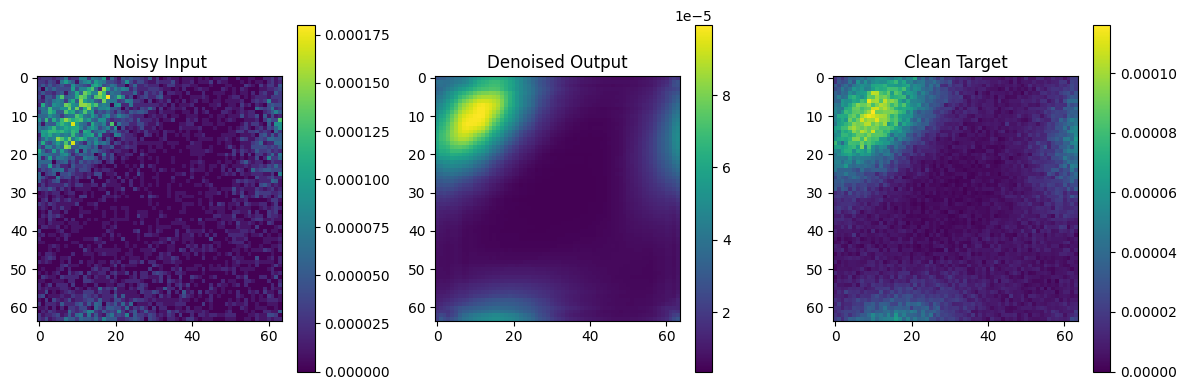

In [8]:
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt



def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_3d_cae(input_shape=(64,64,64,1), dropout_rate=0.2, l2_strength=1e-4):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv3D(16, 3, activation='relu', padding='same', kernel_regularizer=reg)(input_layer)
    x = layers.MaxPooling3D(2)(x)
    x = layers.Conv3D(8, 3, activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling3D(2)(x)

    # Decoder
    x = layers.Conv3D(8, 3, activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling3D(2)(x)
    x = layers.Conv3D(16, 3, activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling3D(2)(x)

    # Final output layer
    x = layers.Conv3D(1, 3, activation='relu', padding='same', kernel_regularizer=reg)(x)

    # Normalize so sum == 8
    output_layer = layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=[1,2,3,4], keepdims=True) + 1e-8) * 8.0)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)
    x_train = x_train[..., np.newaxis]
    x_val   = x_val[..., np.newaxis]
    x_test  = x_test[..., np.newaxis]

    y_train = y_train[..., np.newaxis]
    y_val   = y_val[..., np.newaxis]
    y_test  = y_test[..., np.newaxis]

    # Build and compile model
    input_shape = (64, 64, 64, 1)
    cae = create_simple_3d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=jensen_shannon_divergence_loss)

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=5,
            batch_size=4,
            callbacks=callbacks_list,
            verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test[i:i+1])[0, ..., 0]
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test[i, ..., 0]

    # Plot mid-slice
    z_mid = 64 // 2
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input[:, :, z_mid], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised[:, :, z_mid], cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[:, :, z_mid], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [27]:
print(x_test.shape,"Shape of test set")
# must beat the model predicting the average
test_avg = np.mean(x_test,axis=0)
print(test_avg.shape, "Shape of average of test set")
print(ref_d.shape,"reference shape")
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg[:,:,:,0]-ref_d))

print("prediction of one test sample vs DFT")
print(x_test[0:0+1].shape,"test_shape")
print(cae.predict(x_test[0:0+1])[0,:,:,:,0].shape,ref_d.shape)
print(np.linalg.norm(cae.predict(x_test[0:0+1])[0,:,:,:,0]-ref_d))
print()
print()
print("divergence difference")
print(test_avg.shape)
mean_pred = cae.predict(test_avg.reshape(1,64,64,64,1))[0,:,:,:,0]                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d.copy()))
print("JSD (DAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), ref_d.copy()))
print("JSD (DAE(_i}),y_dft):", jensen_shannon_divergence_loss(cae.predict(x_test[0:0+1])[0,:,:,:,0], ref_d.copy()))


print("not working bettterrr!!!!!!!!")

(500, 64, 64, 64, 1) Shape of test set
(64, 64, 64, 1) Shape of average of test set
(64, 64, 64) reference shape
2 norm difference
Mean vs DFT 2 norm diff
0.00040043202591896483
prediction of one test sample vs DFT
(1, 64, 64, 64, 1) test_shape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(64, 64, 64) (64, 64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
0.0016408655800606217


divergence difference
(64, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
JSD (bar{x_test},y_dft): tf.Tensor(9.7360404e-05, shape=(), dtype=float32)
JSD (DAE(bar{x}),y_dft): tf.Tensor(0.0007782673, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
JSD (DAE(_i}),y_dft): tf.Tensor(0.00073423854, shape=(), dtype=float32)
not working bettterrr!!!!!!!!


In [12]:
a = .82
x_m = np.squeeze(np.mean(x_test.copy(),axis=0))
print(x_m.shape)
print(ref_d.shape)
print("mean:", jensen_shannon_divergence_loss(a*x_m+(1-a)*ref_d, ref_d.copy()))
#print("mean:", jensen_shannon_divergence_loss((1-a)*np.mean(x_test.copy(),axis=0)+a*y_dft[0].copy(), y_dft[0].copy()))
print(1/a**2)

(64, 64, 64)
(64, 64, 64)
mean: tf.Tensor(6.597872e-05, shape=(), dtype=float32)
1.4872099940511603


In [29]:
#check the number of electrons
# need to ensure this is kept true throught taining
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 8.0


Epoch 1/5


2025-07-17 09:06:35.374004: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.38 = (f32[4,128,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,64,64,64]{4,3,2,1,0} %bitcast.6731, f32[128,64,3,3,3]{4,3,2,1,0} %bitcast.6722, f32[128]{0} %bitcast.6781), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="functional_1_1/conv3d_13_1/convolution" source_file="/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-17 09:06:35.760826: E external/local_xla/xla/service/slow_operation_alarm.cc:140] Th

1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0242  

2025-07-17 09:07:47.309333: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.38 = (f32[4,128,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,64,64,64]{4,3,2,1,0} %bitcast.903, f32[128,64,3,3,3]{4,3,2,1,0} %bitcast.910, f32[128]{0} %bitcast.912), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="functional_1_1/conv3d_13_1/convolution" source_file="/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-17 09:07:47.696486: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The o

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - loss: 0.0242 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0045 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


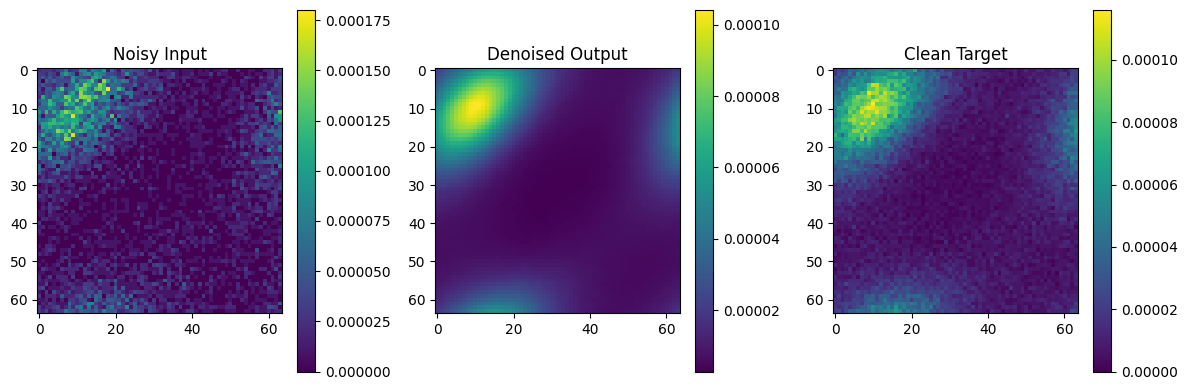

In [30]:
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt



def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_3d_cae(input_shape=(64,64,64,1), dropout_rate=0.2, l2_strength=1e-4):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)

    # Bottleneck
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)

    # Decoder with upsampling
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)


    # Normalize so sum == 8
    output_layer = layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=[1,2,3,4], keepdims=True) + 1e-8) * 8.0)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)


    # Build and compile model
    input_shape = (64, 64, 64, 1)
    cae = create_simple_3d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=jensen_shannon_divergence_loss)

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=5,
            batch_size=4,
            callbacks=callbacks_list,
            verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test[i:i+1])[0, ..., 0]
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test[i, ..., 0]

    # Plot mid-slice
    z_mid = 64 // 2
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input[:, :, z_mid], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised[:, :, z_mid], cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[:, :, z_mid], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [32]:
print(x_test.shape,"Shape of test set")
# must beat the model predicting the average
test_avg = np.mean(x_test,axis=0)
print(test_avg.shape, "Shape of average of test set")
print(ref_d.shape,"reference shape")
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg[:,:,:,0]-ref_d))

print("prediction of one test sample vs DFT")
print(x_test[0:0+1].shape,"test_shape")
print(cae.predict(x_test[0:0+1])[0,:,:,:,0].shape,ref_d.shape)
print(np.linalg.norm(cae.predict(x_test[0:0+1])[0,:,:,:,0]-ref_d))
print()
print()
print("divergence difference")
print(test_avg.shape)
mean_pred = cae.predict(test_avg.reshape(1,64,64,64,1))[0,:,:,:,0]                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d.copy()))
print("JSD (DAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), ref_d.copy()))
print("JSD (DAE(_i}),y_dft):", jensen_shannon_divergence_loss(cae.predict(x_test[0:0+1])[0,:,:,:,0], ref_d.copy()))


print("Working slightly better!!!!!!!!")

(500, 64, 64, 64, 1) Shape of test set
(64, 64, 64, 1) Shape of average of test set
(64, 64, 64) reference shape
2 norm difference
Mean vs DFT 2 norm diff
0.00040043202591896483
prediction of one test sample vs DFT
(1, 64, 64, 64, 1) test_shape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
(64, 64, 64) (64, 64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
0.0003978254910755407


divergence difference
(64, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
JSD (bar{x_test},y_dft): tf.Tensor(9.7360404e-05, shape=(), dtype=float32)
JSD (DAE(bar{x}),y_dft): tf.Tensor(6.967109e-05, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
JSD (DAE(_i}),y_dft): tf.Tensor(7.1515096e-05, shape=(), dtype=float32)
Working slightly better!!!!!!!!


In [35]:
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt



def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_3d_cae(input_shape=(64,64,64,1), dropout_rate=0.2, l2_strength=1e-4):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)
    #x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(input_layer)
    #x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)

    # Bottleneck
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)

    # Decoder with upsampling
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    #x = layers.UpSampling3D((2, 2, 2))(x)
    #x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)


    # Normalize so sum == 8
    output_layer = layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=[1,2,3,4], keepdims=True) + 1e-8) * 8.0)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)


    # Build and compile model
    input_shape = (64, 64, 64, 1)
    cae = create_simple_3d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=jensen_shannon_divergence_loss)

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=5,
            batch_size=4,
            callbacks=callbacks_list,
            verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test[i:i+1])[0, ..., 0]
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test[i, ..., 0]

    # Plot mid-slice
    z_mid = 64 // 2
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input[:, :, z_mid], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised[:, :, z_mid], cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[:, :, z_mid], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


Epoch 1/5


2025-07-17 09:17:08.976228: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.38 = (f32[4,256,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,64,64,64]{4,3,2,1,0} %bitcast.6731, f32[256,64,3,3,3]{4,3,2,1,0} %bitcast.6722, f32[256]{0} %bitcast.6781), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="functional_4_1/conv3d_45_1/convolution" source_file="/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-17 09:17:10.748855: E external/local_xla/xla/service/slow_operation_alarm.cc:140] Th

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0160   

2025-07-17 09:19:27.340692: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-17 09:19:29.357113: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.38 = (f32[4,256,64,64,64]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,64,64,64]{4,3,2,1,0} %bitcast.903, f32[256,64,3,3,3]{4,3,2,1,0} %bitcast.910, f32[256]{0} %bitcast.912), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="functional_4_1/conv3d_45_1/convolution" source_file="/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operati

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 104ms/step - loss: 0.0160 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 2/5


2025-07-17 09:19:48.188006: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.17GiB (rounded to 7698419200)requested by op 
2025-07-17 09:19:48.188533: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-07-17 09:19:48.188548: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 5565, Chunks in use: 5565. 1.36MiB allocated for chunks. 1.36MiB in use in bin. 31.4KiB client-requested in use in bin.
2025-07-17 09:19:48.188555: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 15, Chunks in use: 15. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 7.5KiB client-requested in use in bin.
2025-07-17 09:19:48.188561: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 15, Chunks in use: 15. 20.0KiB allocated for chunks. 20.0KiB in use in bin. 19.1KiB client-requested

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/global/common/software/nersc/pe/conda-envs/25.3.0/python-3.12/nersc-python/lib/python3.12/runpy.py", line 198, in _run_module_as_main

  File "/global/common/software/nersc/pe/conda-envs/25.3.0/python-3.12/nersc-python/lib/python3.12/runpy.py", line 88, in _run_code

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/global/common/software/nersc/pe/conda-envs/25.3.0/python-3.12/nersc-python/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/global/common/software/nersc/pe/conda-envs/25.3.0/python-3.12/nersc-python/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/global/common/software/nersc/pe/conda-envs/25.3.0/python-3.12/nersc-python/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3100, in run_cell

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3155, in _run_cell

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3367, in run_cell_async

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3612, in run_ast_nodes

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code

  File "/tmp/ipykernel_794444/778394294.py", line 90, in <module>

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

Out of memory while trying to allocate 7698419184 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_94924]